<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install joblib
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math

from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#FEATURES AND LABELS  


with open('/content/features_withITO (1).bin','rb') as file:
  temp = pickle.load(file)
  
  
with open('/content/labels_withITO (2).bin','rb') as file:
  l = pickle.load(file)

In [0]:
features =[]
for i in temp:
  features.append(list(i))

labels=[]  
for i in l:
  labels.append(list(i))

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
## 56 BIT (2253,3147)

# features = joblib.load('/content/features56.pkl')
# labels = joblib.load('/content/labels56.pkl')


In [0]:
## 64 BIT (2253,3147)

# features = joblib.load('/content/features64.pkl')
# labels = joblib.load('/content/labels64.pkl')


In [0]:
# # 32 BIT (2253,1035)

# features = joblib.load('/content/features32.pkl')
# labels = joblib.load('/content/labels32.pkl')

In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [7]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3627463510542753161
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14048203491932998529
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9801198336458132381
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13961011317325995200
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:

from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(16, input_shape = (9, ), activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.5))
model.add(Dense(1,  activation = 'relu'))

In [0]:
model.compile(optimizer = Adam(lr = 0.001),loss='mse')
model.summary()

In [0]:
hist = model.fit([x_train_t], [y_train_t], validation_split = 0.33, epochs = 1000, verbose = 1, batch_size = 32, shuffle = True)

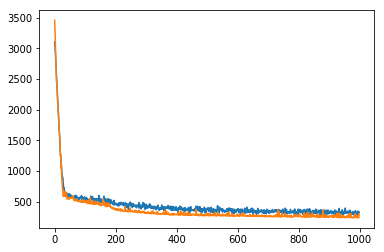

In [32]:
tr = hist.history['loss']
val_ls = hist.history['val_loss']
plt.plot(tr[1:])
plt.plot(val_ls[1:])

In [0]:
predicted = model.predict([x_test_t])


In [0]:
# print(np.shape(y_test_t))
# # print(np.shape(predicted))

actual =[]
pred=[]
se=0
show = np.hstack((y_test_t, predicted))

for i in show:
  se+=(i[0]-i[1])**2
  actual.append(i[0])
  pred.append(i[1])
  
 




In [0]:
rmse = (se/np.size(y_test_t))**0.5

In [36]:
print(rmse)

15.592890611104645


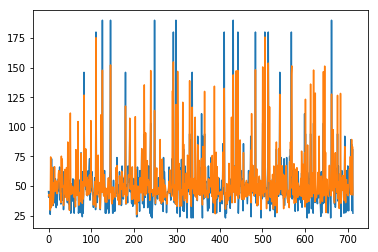

In [0]:
plt.plot(actual)
plt.plot(pred)

In [0]:
print(np.shape(labels))

(2376, 1)


In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(shape = (None,9), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

#Layer 1 
w1 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((9, 15)))
b1 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,15)))

#Layer2 

w2 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((15,25)))
b2 = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,25)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((25,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


In [0]:
hidl1 = tf.add(tf.matmul(x,w1),b1, name ='hidden1')
hidl2 = tf.add(tf.matmul(hidl1,w2),b2, name = 'hidden2')

In [0]:
#outl_batch = tf.compat.v1.layers.batch_normalization(hidl2)
out = tf.add(tf.matmul(hidl2,wo),bo,name = 'output')


In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,out)))

opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

  

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

2802.6108	2329.207
2662.5708	2335.342
2595.0332	3702.0479
4649.389	2710.6392
2737.2039	2708.9219
2870.2727	6137.515
2364.1108	4474.5215
3411.4407	5467.326
3729.396	2839.9624
3196.724	4074.8652
3838.7898	3304.287
3408.8418	3356.63
4886.372	2525.0125
2273.4956	2705.3696
3252.9177	2365.8171
2631.0198	4445.9956
4053.6265	3179.833
2843.413	2107.7534
3464.088	2125.0994
2010.2509	3642.5164
4601.537	3529.4795
5887.593	7295.0483
2921.7244	3003.9358
2551.94	2606.2134
3620.233	3650.2207
5653.857	4548.029
2168.229	2646.965
3298.2651	3419.0308
3604.7854	4321.2773
2753.7432	2892.612
2670.3247	2572.5176
4708.326	2404.7407
3408.212	2964.2834
2731.6802	3311.4045
4102.6914	4198.881
4285.188	3040.0273
2655.809	4632.0073
2198.2063	4871.843
3480.7627	3163.9927
2536.429	2761.181
3057.2393	3738.017
4265.075	3072.9585
4796.6113	4069.8691
3930.3804	2067.3496
2262.175	4186.877
4738.166	5416.1694
2339.774	2747.793
2543.1042	3241.5425
5324.0103	2715.7256
3328.9749	3348.4146
3300.0767	3641.9958
2090.3206	4748.0107

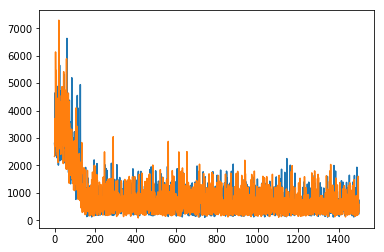

In [38]:
train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(1500):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    save_path = save.save(sess, "/content/final_model.ckpt")
    print('Saved model!')
    
 

In [15]:
print(type(tf.get_default_graph().as_graph_def()))
tf.io.write_graph(tf.get_default_graph().as_graph_def(), '/content/', 'final_train.pbtxt')

<class 'tensorflow.core.framework.graph_pb2.GraphDef'>


'/content/final_train.pbtxt'

In [0]:
with open('/content/final_graph.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())
  

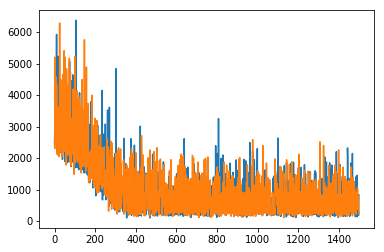

In [17]:
plt.plot(train[1:])
plt.plot(val[1:])

In [27]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(9, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(15, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(15,) dtype=float32_ref>]

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''